# Emotion Classification in Texts using Scikit-learn 

Classifying short messages into five emotion categories. We will prepare our dataset (nltk and regular expressions) and vectorize words using TF-IDF (term frequency-inverse document frequency) metric. Later we will use classifiers provided by scikit-learn and classify sentences into five emotion categories: joy, sadness, anger, fear, and neutral.

### Workflow 
* Importing Dataset
* Text Preprocessing
* Text Representation
* Classifiers: Naive Bayes, Linear Regression, Random Rorrrest, SVM
* Evaluation: F1 scores and Confussion Matrix
* Saving the Model


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

## 1. Import Dataset

Text-Emotion Dataset was split into training 70% and testing 30%


In [2]:
df_train = pd.read_csv('unified_data_train.csv')
df_test = pd.read_csv('unified_data_test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['neutral', 'joy', 'sadness', 'fear', 'anger']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))
print(data.Emotion.value_counts())


size of training set: 152409
size of validation set: 38486
neutral    104338
joy         39299
sadness     17951
fear        17827
anger       11480
Name: Emotion, dtype: int64


### *Plotting confusion matrix for later evaluation 

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## 2. Text Preprocessing

Here are some preprocessing steps to consider:
* Removing noise: html markups, urls, non-ascii symbols, trailing whitespace etc.
* Removing punctuation
* Normalizing emoticons
* Negation handling
* Tokenization: split text into word tokens
* Stopword removal
* Stemming or lemmatization

However, most of these steps did not improve our classification results. Since our data was mostly taken from written dialogs it was almost ready to use.

In [4]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub
    (r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

## 3. Text Representation

Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tekenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

In [5]:
import re, string
from string import punctuation
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

from nltk.corpus import stopwords
sw = stopwords.words('english')

def  normalize (df):
    contents=df.dropna().values
    

    
    
    for i in range (contents.shape[0]):
        contents[i]=contents[i].replace(",", " ")
        
    all_contents = [''.join([c for c in i if c not in punctuation]) for i in contents]
    all_contents = [i.lower() for i in all_contents]
    all_contents= [i.split() for i in all_contents]
    
    for i in range (len(all_contents)):
        all_contents[i]=remove_noise(all_contents[i],sw)
    
    

       
    

    
    return all_contents

In [6]:
text=normalize(data.Text)
text

[['know',
  'barack',
  'obama',
  'friday',
  'blaiseff',
  'think',
  'book',
  'flight',
  'asap'],
 ['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'early',
  'start',
  'freakin',
  'part'],
 ['dannycastillo', 'want', 'trade', 'someone', 'houston', 'ticket', 'one'],
 ['cant', 'fall', 'asleep'],
 ['miss', 'bly', 'bus'],
 ['feel', 'strong', 'contraction', 'want', 'go', 'httpplurkcompwxidk'],
 ['socal', 'stoke', 'maybe', 'tomorrow'],
 ['screw', 'davidbrussee', '3', 'week'],
 ['work', 'afternoon'],
 ['gabbyisactive', 'aw', 'would', 'unfollow', 'would', 'would', 'cry'],
 ['creyes',
  'middle',
  'school',
  'elem',
  'high',
  'school',
  'remain',
  'open',
  'need',
  'credit',
  'graduate',
  'cali',
  'break'],
 ['jakeboyd',
  'oh',
  'noooo',
  'blow',
  'tire',
  'youre',
  'reaaaally',
  'go',
  'send',
  'batman',
  'smoke'],
 ['wnna', 'take', 'bath'],
 ['chocolate', 'milk', 'much', 'good', 'straw', 'lack', 'say', 'straw'],
 ['djmicdamn', 'hey', 'yu', 'lil', 'fucke

In [7]:
text1 = [' '.join(i) for i in text]


In [8]:
text=text1

In [9]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

## 4. Classifiers

###  Naive Bayes

Accuracy: 55.95%

F1 Score: 55.95

COnfusion Matrix:
 [[    2     0    54  2222     4]
 [    0    65    65  3466     4]
 [    0     1   366  7472     2]
 [    0     0    13 21094     0]
 [    0     8   136  3508     4]]


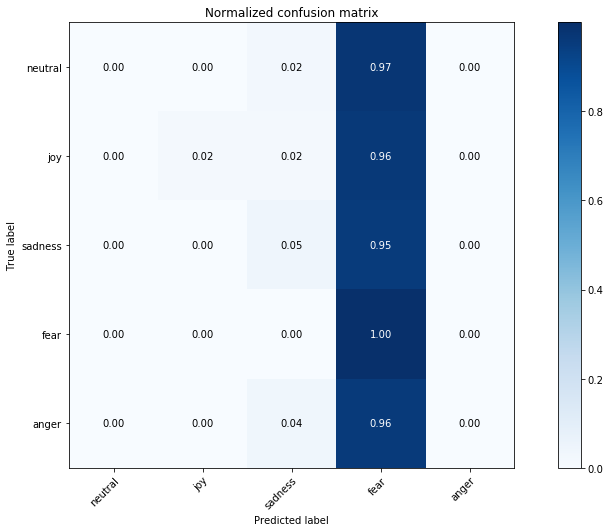

In [10]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Random Forrest

Accuracy: 62.88%

F1 Score: 62.88

COnfusion Matrix:
 [[  433   242   317   986   304]
 [  210   667   567  1847   309]
 [  162   231  3204  4018   226]
 [   50   153  1312 19483   109]
 [  358   342   653  1891   412]]


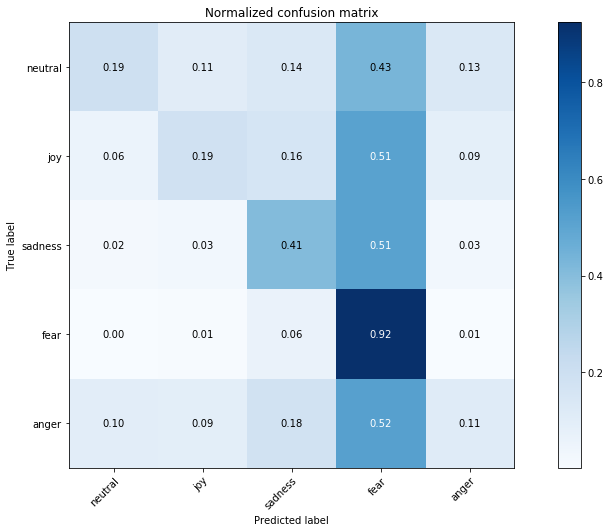

In [11]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Logistic Regression

C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 66.68%

F1 Score: 66.68

COnfusion Matrix:
 [[  590   128   264   955   345]
 [  206   792   543  1686   373]
 [  144   120  3741  3589   247]
 [   30   144  1048 19724   161]
 [  391   252   637  1560   816]]


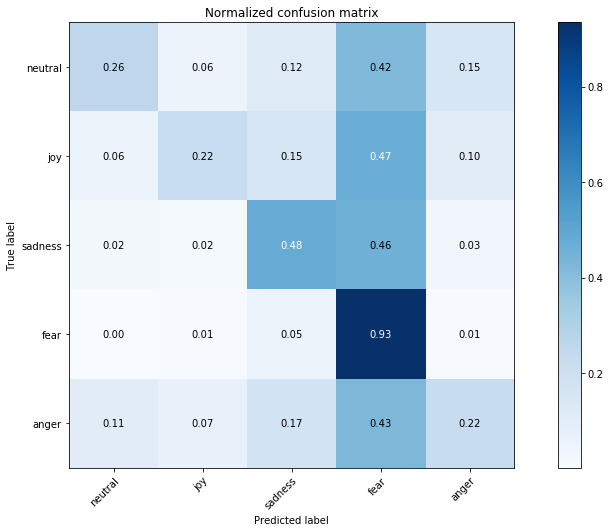

In [12]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Linear Support Vector

Accuracy: 67.86%

F1 Score: 67.86

COnfusion Matrix:
 [[  749   194   236   721   382]
 [  252   968   523  1462   395]
 [  166   177  3893  3313   292]
 [   77   164  1089 19599   178]
 [  426   327   650  1347   906]]


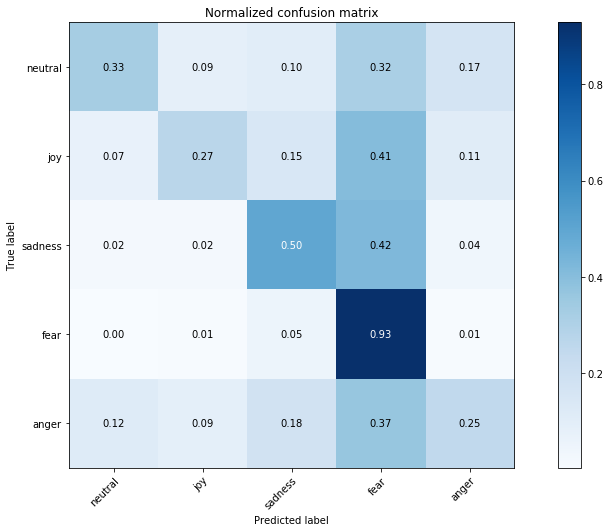

In [13]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## 4. Saving the tf-idf + SVM Model 


In [14]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [15]:
# save the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/tfidf_svm.sav'

In [ ]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!' 
model.predict([message])